# Use Community Shared LoRAs and Textual Inversion

## Technical requirements

In [1]:
%pip install transformers accelerate PEFT
%pip install diffusers==0.23.0

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


## Prepare Stable Diffusion pipeline

In [1]:
import torch
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
    , torch_dtype = torch.bfloat16
).to("cuda:0")

/home/andrewzhu/storage_1t_1/az_git_folder/Using-Stable-Diffusion-with-Python/sd_book_prd_p310_venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/andrewzhu/storage_1t_1/az_git_folder/Using-Stable-Diffusion-with-Python/sd_book_prd_p310_venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

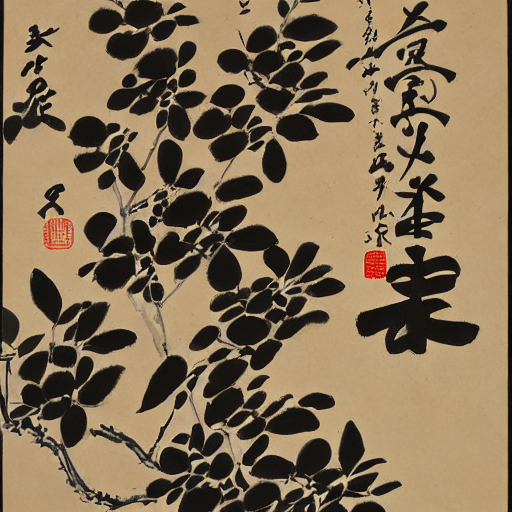

In [2]:
prompt = """
shukezouma, shuimobysim ,a branch of flower, traditional chinese ink painting
"""
image = pipeline(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
).images[0]
display(image)

## Use MixinLoraLoader

### Use lora with default settings

  0%|          | 0/50 [00:00<?, ?it/s]

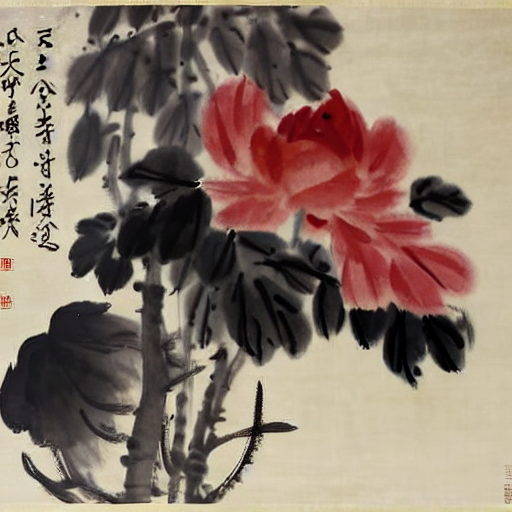

In [3]:
# load lora
pipeline.load_lora_weights(
    "andrewzhu/MoXinV1"
    , weight_name   = "MoXinV1.safetensors"
    , adapter_name  = "MoXinV1"
)

image = pipeline(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
).images[0]
display(image)

### Load LoRA with weight

  0%|          | 0/50 [00:00<?, ?it/s]

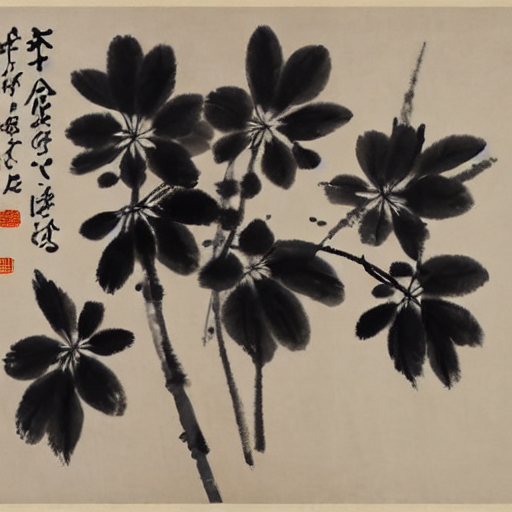

In [4]:
pipeline.set_adapters(
    ["MoXinV1"]
    , adapter_weights=[0.5]
)
image = pipeline(
    prompt = prompt
    , generator = torch.Generator("cuda").manual_seed(1)
).images[0]
display(image)

In [5]:
pipeline.load_lora_weights(
    "andrewzhu/civitai-light-shadow-lora"
    , weight_name   = "light_and_shadow.safetensors"
    , adapter_name  = "light_and_shadow"
)

  0%|          | 0/50 [00:00<?, ?it/s]

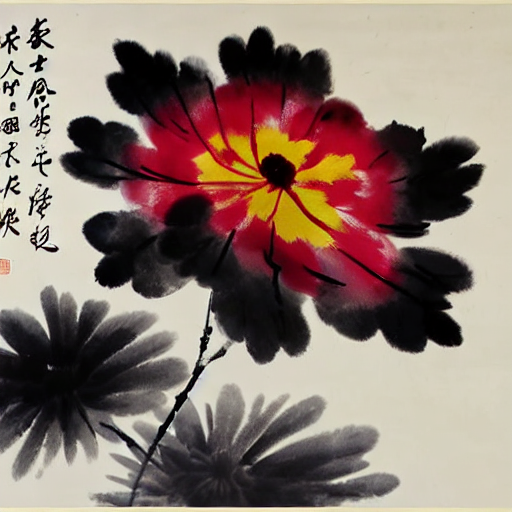

In [6]:
pipeline.set_adapters(
    ["MoXinV1", "light_and_shadow"]
    , adapter_weights=[0.5,1.0]
)
prompt = """
shukezouma, shuimobysim ,a branch of flower, traditional chinese ink painting,STRRY LIGHT,COLORFUL
"""
image = pipeline(
    prompt = prompt
    , generator = torch.Generator("cuda").manual_seed(1)
).images[0]
display(image)

## Dive into LoRA

### Step 1. Find $A$ and $B$ weight matrix from the LoRA file

In [7]:
# load lora file
from safetensors.torch import load_file
# Note you need to change the file path point to your safetensors file
lora_path = "/home/andrewzhu/.cache/huggingface/hub/models--andrewzhu--MoXinV1/snapshots/7dbe7e0c8430ab549f2a0a45bc7f875e58c2eb7d/MoXinV1.safetensors"
state_dict = load_file(lora_path)
for key in state_dict:
    print(key)

lora_te_text_model_encoder_layers_0_mlp_fc1.alpha
lora_te_text_model_encoder_layers_0_mlp_fc1.lora_down.weight
lora_te_text_model_encoder_layers_0_mlp_fc1.lora_up.weight
lora_te_text_model_encoder_layers_0_mlp_fc2.alpha
lora_te_text_model_encoder_layers_0_mlp_fc2.lora_down.weight
lora_te_text_model_encoder_layers_0_mlp_fc2.lora_up.weight
lora_te_text_model_encoder_layers_0_self_attn_k_proj.alpha
lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight
lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_up.weight
lora_te_text_model_encoder_layers_0_self_attn_out_proj.alpha
lora_te_text_model_encoder_layers_0_self_attn_out_proj.lora_down.weight
lora_te_text_model_encoder_layers_0_self_attn_out_proj.lora_up.weight
lora_te_text_model_encoder_layers_0_self_attn_q_proj.alpha
lora_te_text_model_encoder_layers_0_self_attn_q_proj.lora_down.weight
lora_te_text_model_encoder_layers_0_self_attn_q_proj.lora_up.weight
lora_te_text_model_encoder_layers_0_self_attn_v_proj.alpha
lora

In [8]:
# find the layer name
LORA_PREFIX_UNET = 'lora_unet'
LORA_PREFIX_TEXT_ENCODER = 'lora_te'
for key in state_dict:
    if 'text' in key:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_TEXT_ENCODER+'_')[-1].split('_')
        curr_layer = pipeline.text_encoder
    else:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_UNET+'_')[-1].split('_')
        curr_layer = pipeline.unet

print(layer_infos)

['up', 'blocks', '3', 'attentions', '2', 'transformer', 'blocks', '0', 'ff', 'net', '2']


### Step 2. Find the corresponding checkpoint model layer name

In [ ]:
# take a look at the checkpoint unet model structure
unet = pipeline.unet
modules = unet.named_modules()
for child_name, child_module in modules:
    print("child_module:",child_module)

In [9]:
# find the layer name
for key in state_dict:
    if 'text' in key:
        layer_infos = key.split('.')[0].split("lora_unet_")[-1].split('_')
        curr_layer = pipeline.text_encoder
    else:
        layer_infos = key.split('.')[0].split("lora_te_")[-1].split('_')
        curr_layer = pipeline.unet
    
    # loop through the layers to find the target layer
    temp_name = layer_infos.pop(0)
    # should be -1, but use 0 here to avoid popping item from empty list
    while len(layer_infos) > 0:
        try:
            curr_layer = curr_layer.__getattr__(temp_name)
            # no exception means the layer is found
            if len(layer_infos) > 0:
                temp_name = layer_infos.pop(0)
            # layer found but length is 0, 
            # break the loop and curr_layer keep point to the current layer
            elif len(layer_infos) == 0:
                break
        except Exception:
            # no such layer exist, pop next name and try again
            if len(temp_name) > 0:
                temp_name += '_'+layer_infos.pop(0)
            else:
                # temp_name is empty
                temp_name = layer_infos.pop(0)

### Step 3. Update the checkpoint model weights

In [10]:
from safetensors.torch import load_file

def load_lora(
    pipeline
    , lora_path
    , lora_weight = 0.5
    , device = 'cpu'
):
    state_dict = load_file(lora_path, device=device)
    LORA_PREFIX_UNET = 'lora_unet'
    LORA_PREFIX_TEXT_ENCODER = 'lora_te'

    alpha = lora_weight
    visited = []

    # directly update weight in diffusers model
    for key in state_dict:
        # as we have set the alpha beforehand, so just skip
        if '.alpha' in key or key in visited:
            continue
            
        if 'text' in key:
            layer_infos = key.split('.')[0].split(LORA_PREFIX_TEXT_ENCODER+'_')[-1].split('_')
            curr_layer = pipeline.text_encoder
        else:
            layer_infos = key.split('.')[0].split(LORA_PREFIX_UNET+'_')[-1].split('_')
            curr_layer = pipeline.unet

        # find the target layer
        # loop through the layers to find the target layer
        temp_name = layer_infos.pop(0)
        while len(layer_infos) > -1:
            try:
                curr_layer = curr_layer.__getattr__(temp_name)
                # no exception means the layer is found
                if len(layer_infos) > 0:
                    temp_name = layer_infos.pop(0)
                # layer found but length is 0, 
                # break the loop and curr_layer keep point to the current layer
                elif len(layer_infos) == 0:
                    break
            except Exception:
                # no such layer exist, pop next name and try again
                if len(temp_name) > 0:
                    temp_name += '_'+layer_infos.pop(0)
                else:
                    # temp_name is empty
                    temp_name = layer_infos.pop(0)
        
        # org_forward(x) + lora_up(lora_down(x)) * multiplier
        # ensure the sequence of lora_up(A) then lora_down(B)
        pair_keys = []
        if 'lora_down' in key:
            pair_keys.append(key.replace('lora_down', 'lora_up'))
            pair_keys.append(key)
        else:
            pair_keys.append(key)
            pair_keys.append(key.replace('lora_up', 'lora_down'))
        
        # update weight
        if len(state_dict[pair_keys[0]].shape) == 4:
            # squeeze(3) and squeeze(2) remove dimensions of size 1 from the tensor to make the tensor more compact
            weight_up = state_dict[pair_keys[0]].squeeze(3).squeeze(2).to(torch.float32)
            weight_down = state_dict[pair_keys[1]].squeeze(3).squeeze(2).to(torch.float32)
            curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down).unsqueeze(2).unsqueeze(3)
        else:
            weight_up = state_dict[pair_keys[0]].to(torch.float32)
            weight_down = state_dict[pair_keys[1]].to(torch.float32)
            curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down)
            
        # update visited list, ensure no duplicated weight is processed. 
        for item in pair_keys:
            visited.append(item)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

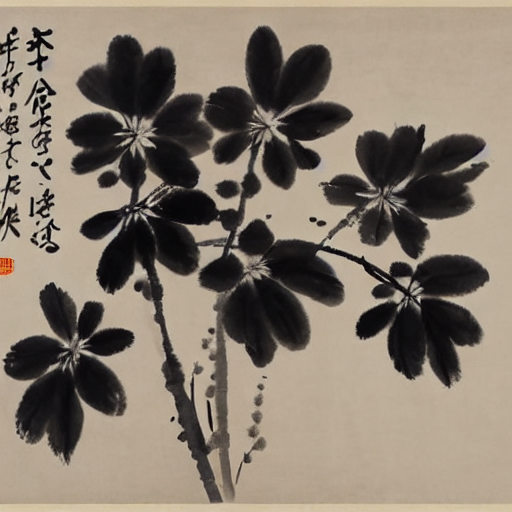

In [11]:
pipeline = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
    , torch_dtype = torch.bfloat16
).to("cuda:0")

load_lora(
    pipeline = pipeline
    , lora_path = lora_path
    , lora_weight = 0.5
    , device = "cuda"
)

prompt = """
shukezouma, shuimobysim ,a branch of flower, traditional chinese ink painting
"""
image = pipeline(
    prompt = prompt
    , generator = torch.Generator("cuda").manual_seed(1)
).images[0]
display(image)